In [1]:
import numpy as np
import pandas as pd
import os,sys
sys.path.append('../')
from statisticalTools.simplifiedLikelihoods import Data,UpperLimitComputer
pd.set_option('display.max_rows', 200)

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [3]:
# Read the number of signal events, background and data for each (limit setting) SR
# for a given benchmark model.
srs = ['SR-Trk-IBL0_Low','SR-Trk-IBL0_High','SR-Trk-IBL1',
       'SR-Mu-IBL0_Low','SR-Mu-IBL0_High','SR-Mu-IBL1']
distLabel = 'massdistribution'

dataDict = {'SR' : [], 'mass_GeV' : [], 'mass_GeV_LOW' : [], 
            'mass_GeV_HIGH' : [], 'Background' : [],
            'BackgroundError' : [], 'Gluino_2200GeV_10ns' : [], 
            'Chargino_1300GeV_10ns' :  [], 'Stau_400GeV_10ns' : [], 
            'Data' : [], 'DataError' : []}

for sr in srs:
    f = os.path.join('./HEPData-ins2080541-v1-csv/',sr+distLabel+'.csv')
    print(f)
    with open(f,'r') as ff:
        data = ff.read()
    blocks = data.split('#: REGION')[1:]
    for ib,b in enumerate(blocks):
        b = b.replace('sys,background +','BackgroundError')
        b = b.replace('sys,background -','sys-background_minus')
        b = b.replace('stat +','DataError')
        b = b.replace('stat -','stat_minus')
        b = b.replace('Data [Entries / 100 GeV]','Data')
        b = b.replace('Background [Entries / 100 GeV]','Background')
        b = b.replace(r'$m(\tilde{g}) = 2.2 ~\text{TeV}, m(\tilde{\chi}_{1}^{0}) = 100 ~\text{GeV}, \tau(\tilde{g}) = 10 ~\text{ns}$ [Entries / 100 GeV]',
                     'Gluino_2200GeV_10ns')
        b = b.replace(r"$m(\tilde{\chi}_{1}^{\pm}) = 1.3 ~\text{TeV}, \tau(\tilde{\chi}_{1}^{\pm}) = 10 ~\text{ns}$ [Entries / 100 GeV]",
                     'Chargino_1300GeV_10ns')
        b = b.replace(r"$m(\tilde{\tau}) =  400 ~\text{GeV}, \tau(\tilde{\tau}) = 10 ~\text{ns}$ [Entries / 100 GeV]",
                     'Stau_400GeV_10ns')
        blockData = np.genfromtxt(b.split('\n'),names=True,delimiter=',',skip_header=1,comments='#')
        model = blockData.dtype.names[3]
        # Store the common mass bins
        if ib == 0:
            dataDict['SR'] += [sr]*len(blockData)
            dataDict['mass_GeV'] += blockData['mass_GeV'].tolist()
            dataDict['mass_GeV_LOW'] += blockData['mass_GeV_LOW'].tolist()
            dataDict['mass_GeV_HIGH'] += blockData['mass_GeV_HIGH'].tolist()
            dataScale = (blockData['mass_GeV_HIGH']-blockData['mass_GeV_LOW'])/100.0
        # Store the model-specific data
        dataDict[model] += (dataScale*blockData[model]).tolist()
        if model == 'Background':
            dataDict['BackgroundError'] += (dataScale*blockData['BackgroundError']).tolist()
        if model == 'Data':
            dataDict['DataError'] += (dataScale*blockData['DataError']).tolist()
        
    

./HEPData-ins2080541-v1-csv/SR-Trk-IBL0_Lowmassdistribution.csv
./HEPData-ins2080541-v1-csv/SR-Trk-IBL0_Highmassdistribution.csv
./HEPData-ins2080541-v1-csv/SR-Trk-IBL1massdistribution.csv
./HEPData-ins2080541-v1-csv/SR-Mu-IBL0_Lowmassdistribution.csv
./HEPData-ins2080541-v1-csv/SR-Mu-IBL0_Highmassdistribution.csv
./HEPData-ins2080541-v1-csv/SR-Mu-IBL1massdistribution.csv


In [4]:
dataDF = pd.DataFrame.from_dict(dataDict)

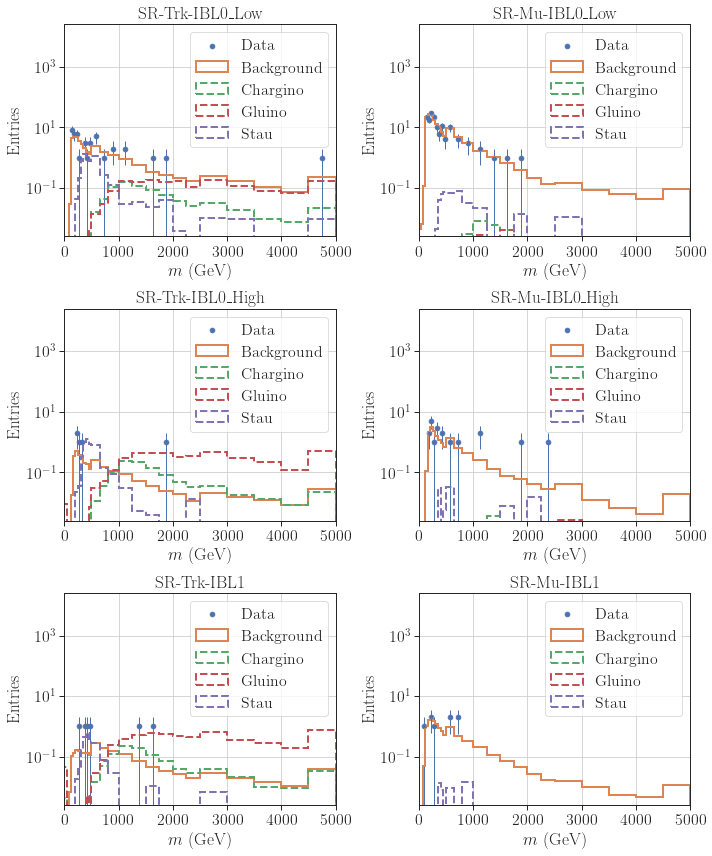

In [5]:
fig,axarr = plt.subplots(ncols=2,nrows=3,figsize=(10,12))
atlasSRList = ['SR-Trk-IBL0_Low','SR-Mu-IBL0_Low','SR-Trk-IBL0_High','SR-Mu-IBL0_High',
              'SR-Trk-IBL1','SR-Mu-IBL1']
for isr,sr in enumerate(atlasSRList):
    ax = axarr.reshape(-1)[isr]
    
    dataSR = dataDF[(dataDF['SR'] == sr)]
    ax.scatter(dataSR['mass_GeV'],dataSR['Data'],label='Data')
    ax.errorbar(dataSR['mass_GeV'],dataSR['Data'],yerr=dataSR['DataError'],
                marker = '.', elinewidth=1.0, drawstyle = 'steps-mid',linewidth=0.0)
    
    
    ax.hist(dataSR['mass_GeV'],bins=dataSR['mass_GeV_LOW'].tolist()+dataSR['mass_GeV_HIGH'][-1:].tolist(),
             weights=dataSR['Background'],
             label='Background',histtype='step',linewidth=2)
    ax.hist(dataSR['mass_GeV'],bins=dataSR['mass_GeV_LOW'].tolist()+dataSR['mass_GeV_HIGH'][-1:].tolist(),
             weights=dataSR['Chargino_1300GeV_10ns'],
             label='Chargino',histtype='step',linestyle='--',linewidth=2)
    ax.hist(dataSR['mass_GeV'],bins=dataSR['mass_GeV_LOW'].tolist()+dataSR['mass_GeV_HIGH'][-1:].tolist(),
             weights=dataSR['Gluino_2200GeV_10ns'],
             label='Gluino',histtype='step',linestyle='--',linewidth=2)
    ax.hist(dataSR['mass_GeV'],bins=dataSR['mass_GeV_LOW'].tolist()+dataSR['mass_GeV_HIGH'][-1:].tolist(),
             weights=dataSR['Stau_400GeV_10ns'],
             label='Stau',histtype='step',linestyle='--',linewidth=2)

    ax.set_xlim(0.,5000.)
    ax.set_ylim(2.5e-3,2.5e4)
    ax.set_yscale('log')
    ax.set_title('%s' %sr)
    ax.set_xlabel(r'$m$ (GeV)')
    ax.set_ylabel('Entries')
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

In [6]:
targetMass = 1300.
lowMass = 1000.0
highMass = 2200.0
model = 'Chargino_1300GeV_10ns'

In [7]:
dataMass = dataDF[(dataDF['mass_GeV_LOW'] >= lowMass) 
                  & (dataDF['mass_GeV_HIGH']<= highMass)]
srs = []
ns = []
nbg = []
nobs = []
nbgError = []
for sr in dataMass['SR'].unique():
    srData = dataMass[dataMass['SR'] == sr]
    srs.append(sr)
    nbg.append(sum(srData['Background'].tolist()))
    nobs.append(sum(srData['Data'].tolist()))
    ns.append(sum(srData[model].tolist()))
    nbgError.append(np.sqrt(sum(srData['BackgroundError']**2)))

In [8]:
# Assume diagonal covariant matix
covMatrix = np.diag(np.array(nbgError)**2)

In [9]:
data = Data(observed=nobs, backgrounds=nbg, covariance=covMatrix,nsignal=ns,deltas_rel=0.2)
dataExp = Data(observed=nbg, backgrounds=nbg, covariance=covMatrix,nsignal=ns,deltas_rel=0.2)
ulComp = UpperLimitComputer()
ul = ulComp.getUpperLimitOnMu(data)
ulExp = ulComp.getUpperLimitOnMu(dataExp)

In [10]:
# From ATLAS
totalXsecPB = 0.000322
atlasUL = 0.00164
atlasULexp = 0.000696
# Calculated UL (assuming uncorrelated SRs)
xsecUL = totalXsecPB*ul
xsecULexp = totalXsecPB*ulExp
print('Observed:')
print('ATLAS = %1.2e, Toy Calculation = %1.2e' %(atlasUL,xsecUL))
print('\nExpected:')
print('ATLAS = %1.2e, Toy Calculation = %1.2e' %(atlasULexp,xsecULexp))

Observed:
ATLAS = 1.64e-03, Toy Calculation = 1.69e-03

Expected:
ATLAS = 6.96e-04, Toy Calculation = 6.68e-04
